# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

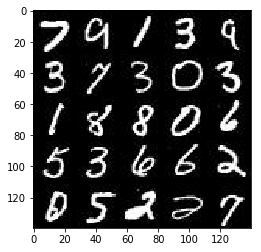

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

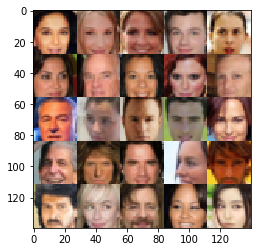

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="image")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # layer 1 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # layer 2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # layer 3
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # output
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        
        #layer 1
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.reshape(x1, (-1,7,7,256))
        x1 = tf.maximum(alpha * x1, x1)
        
        # layer 2
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        #layer 3
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        #layer 4
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    
    d_real_out, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_image, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_image, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    steps = 0
    show_every = 100
    print_every = 25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescale input to [-1,1]
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    d_opt, feed_dict={input_image: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_opt, feed_dict={input_image: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_image: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_image: batch_images, input_z: batch_z})
                    
                    print("Epoch: {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0/2... Discriminator Loss: 1.4619... Generator Loss: 2.5548
Epoch: 0/2... Discriminator Loss: 1.5751... Generator Loss: 0.3998
Epoch: 0/2... Discriminator Loss: 1.2900... Generator Loss: 1.5575


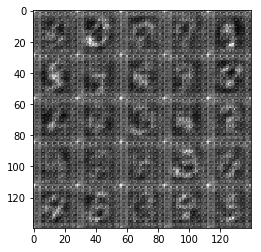

Epoch: 0/2... Discriminator Loss: 1.3245... Generator Loss: 0.4941
Epoch: 0/2... Discriminator Loss: 1.3428... Generator Loss: 1.6741
Epoch: 0/2... Discriminator Loss: 1.1298... Generator Loss: 0.5477
Epoch: 0/2... Discriminator Loss: 0.9964... Generator Loss: 0.8180


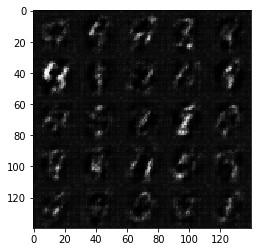

Epoch: 0/2... Discriminator Loss: 1.0337... Generator Loss: 0.6487
Epoch: 0/2... Discriminator Loss: 1.0985... Generator Loss: 0.5514
Epoch: 0/2... Discriminator Loss: 0.9933... Generator Loss: 0.7186
Epoch: 0/2... Discriminator Loss: 1.3231... Generator Loss: 1.8696


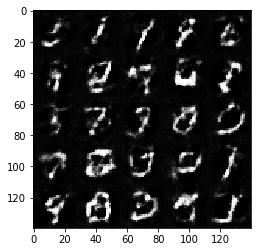

Epoch: 0/2... Discriminator Loss: 1.4464... Generator Loss: 2.0934
Epoch: 0/2... Discriminator Loss: 1.2792... Generator Loss: 0.4406
Epoch: 0/2... Discriminator Loss: 1.0103... Generator Loss: 0.7671
Epoch: 0/2... Discriminator Loss: 1.2197... Generator Loss: 0.4542


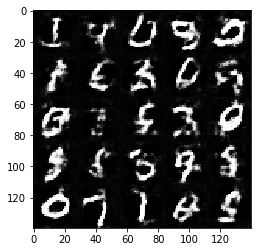

Epoch: 0/2... Discriminator Loss: 1.0313... Generator Loss: 1.2011
Epoch: 0/2... Discriminator Loss: 1.0711... Generator Loss: 0.5937
Epoch: 0/2... Discriminator Loss: 0.9838... Generator Loss: 0.7044
Epoch: 0/2... Discriminator Loss: 1.0790... Generator Loss: 0.6210


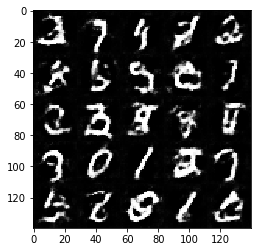

Epoch: 0/2... Discriminator Loss: 1.3159... Generator Loss: 1.7758
Epoch: 0/2... Discriminator Loss: 0.9898... Generator Loss: 0.7184
Epoch: 0/2... Discriminator Loss: 1.1878... Generator Loss: 0.5173
Epoch: 0/2... Discriminator Loss: 1.0873... Generator Loss: 0.7736


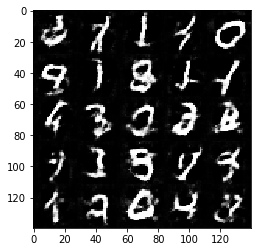

Epoch: 0/2... Discriminator Loss: 0.9104... Generator Loss: 1.1459
Epoch: 0/2... Discriminator Loss: 0.9154... Generator Loss: 0.8348
Epoch: 0/2... Discriminator Loss: 0.9880... Generator Loss: 0.7652
Epoch: 0/2... Discriminator Loss: 0.9955... Generator Loss: 0.8842


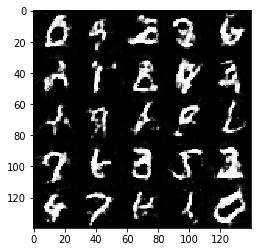

Epoch: 0/2... Discriminator Loss: 1.0956... Generator Loss: 0.6240
Epoch: 0/2... Discriminator Loss: 1.0087... Generator Loss: 0.6535
Epoch: 0/2... Discriminator Loss: 0.8830... Generator Loss: 1.4445
Epoch: 0/2... Discriminator Loss: 1.2999... Generator Loss: 0.4878


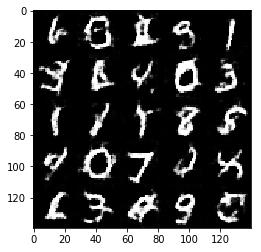

Epoch: 0/2... Discriminator Loss: 0.9897... Generator Loss: 0.8575
Epoch: 0/2... Discriminator Loss: 0.8748... Generator Loss: 0.8458
Epoch: 0/2... Discriminator Loss: 1.3846... Generator Loss: 0.3996
Epoch: 0/2... Discriminator Loss: 0.9790... Generator Loss: 1.2425


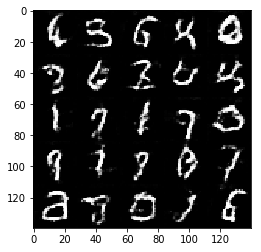

Epoch: 0/2... Discriminator Loss: 1.0987... Generator Loss: 0.6710
Epoch: 0/2... Discriminator Loss: 1.6926... Generator Loss: 0.2654
Epoch: 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.5359
Epoch: 1/2... Discriminator Loss: 0.9784... Generator Loss: 0.8930


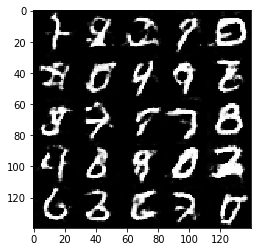

Epoch: 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.7149
Epoch: 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.3177
Epoch: 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.4286
Epoch: 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.6360


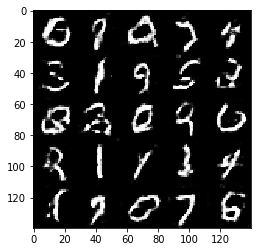

Epoch: 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.7051
Epoch: 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.4837
Epoch: 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.3645
Epoch: 1/2... Discriminator Loss: 0.9080... Generator Loss: 0.8015


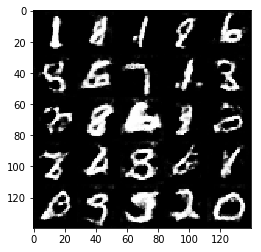

Epoch: 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.0685
Epoch: 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.5909
Epoch: 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.4981
Epoch: 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.5635


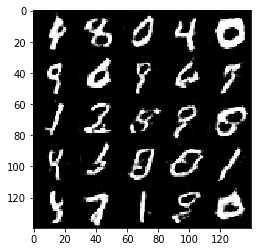

Epoch: 1/2... Discriminator Loss: 1.1018... Generator Loss: 0.5703
Epoch: 1/2... Discriminator Loss: 2.5778... Generator Loss: 0.1050
Epoch: 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.3781
Epoch: 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.4301


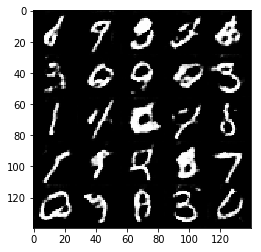

Epoch: 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.3370
Epoch: 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.5439
Epoch: 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.6304
Epoch: 1/2... Discriminator Loss: 1.0814... Generator Loss: 0.5985


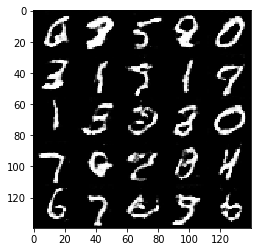

Epoch: 1/2... Discriminator Loss: 1.2692... Generator Loss: 2.0263
Epoch: 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.2718
Epoch: 1/2... Discriminator Loss: 0.7967... Generator Loss: 0.8879
Epoch: 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.8124


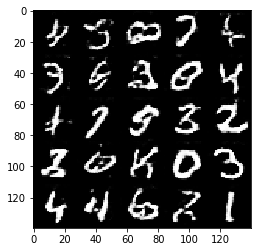

Epoch: 1/2... Discriminator Loss: 0.9075... Generator Loss: 1.6113
Epoch: 1/2... Discriminator Loss: 1.4180... Generator Loss: 2.1805
Epoch: 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.4033
Epoch: 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.2653


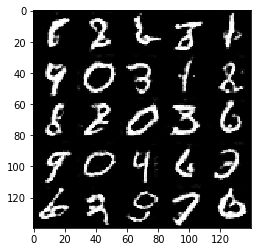

Epoch: 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.3384
Epoch: 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.4052
Epoch: 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.6755
Epoch: 1/2... Discriminator Loss: 0.9758... Generator Loss: 0.6710


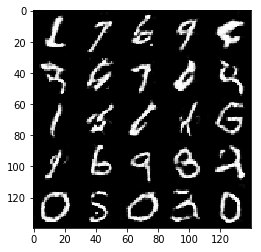

Epoch: 1/2... Discriminator Loss: 1.3982... Generator Loss: 2.6100
Epoch: 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.5127
Epoch: 1/2... Discriminator Loss: 1.5932... Generator Loss: 0.3211


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0/1... Discriminator Loss: 0.6822... Generator Loss: 1.0612
Epoch: 0/1... Discriminator Loss: 1.2843... Generator Loss: 1.4547
Epoch: 0/1... Discriminator Loss: 1.5749... Generator Loss: 2.1327


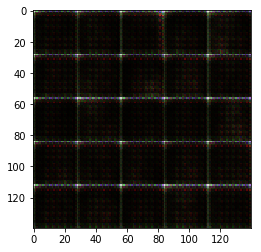

Epoch: 0/1... Discriminator Loss: 1.0943... Generator Loss: 1.2936
Epoch: 0/1... Discriminator Loss: 1.5383... Generator Loss: 0.3394
Epoch: 0/1... Discriminator Loss: 1.8593... Generator Loss: 0.3431
Epoch: 0/1... Discriminator Loss: 1.1991... Generator Loss: 1.0723


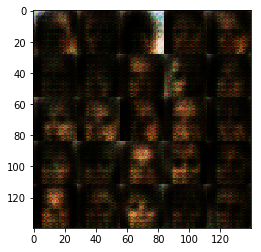

Epoch: 0/1... Discriminator Loss: 1.2458... Generator Loss: 1.3802
Epoch: 0/1... Discriminator Loss: 1.7298... Generator Loss: 0.2803
Epoch: 0/1... Discriminator Loss: 1.2595... Generator Loss: 1.0992
Epoch: 0/1... Discriminator Loss: 1.3261... Generator Loss: 0.5867


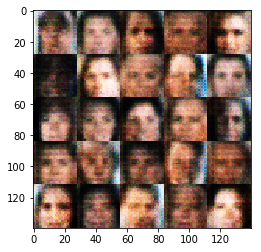

Epoch: 0/1... Discriminator Loss: 1.2001... Generator Loss: 0.7276
Epoch: 0/1... Discriminator Loss: 1.3735... Generator Loss: 0.8321
Epoch: 0/1... Discriminator Loss: 1.2936... Generator Loss: 1.0250
Epoch: 0/1... Discriminator Loss: 1.1945... Generator Loss: 0.9117


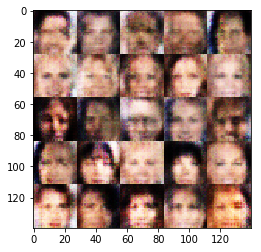

Epoch: 0/1... Discriminator Loss: 1.0734... Generator Loss: 0.9817
Epoch: 0/1... Discriminator Loss: 1.2758... Generator Loss: 0.7608
Epoch: 0/1... Discriminator Loss: 1.3715... Generator Loss: 0.6590
Epoch: 0/1... Discriminator Loss: 1.3188... Generator Loss: 0.5404


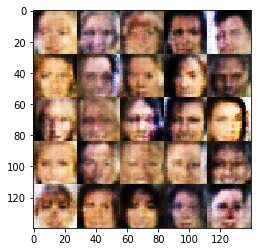

Epoch: 0/1... Discriminator Loss: 1.4300... Generator Loss: 1.1154
Epoch: 0/1... Discriminator Loss: 1.5459... Generator Loss: 1.1334
Epoch: 0/1... Discriminator Loss: 1.2129... Generator Loss: 1.0696
Epoch: 0/1... Discriminator Loss: 1.8152... Generator Loss: 0.2475


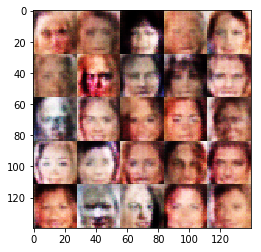

Epoch: 0/1... Discriminator Loss: 1.3123... Generator Loss: 1.2752
Epoch: 0/1... Discriminator Loss: 1.2298... Generator Loss: 0.6308
Epoch: 0/1... Discriminator Loss: 1.2061... Generator Loss: 0.7546
Epoch: 0/1... Discriminator Loss: 1.5355... Generator Loss: 1.5751


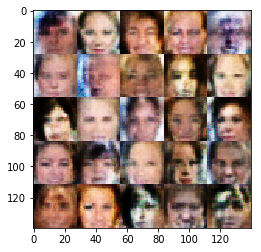

Epoch: 0/1... Discriminator Loss: 1.0278... Generator Loss: 0.8777
Epoch: 0/1... Discriminator Loss: 1.0897... Generator Loss: 1.0968
Epoch: 0/1... Discriminator Loss: 0.9507... Generator Loss: 0.8155
Epoch: 0/1... Discriminator Loss: 0.7146... Generator Loss: 2.0932


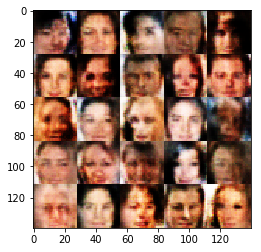

Epoch: 0/1... Discriminator Loss: 1.5442... Generator Loss: 0.3016
Epoch: 0/1... Discriminator Loss: 1.3753... Generator Loss: 0.3703
Epoch: 0/1... Discriminator Loss: 0.6202... Generator Loss: 1.4605
Epoch: 0/1... Discriminator Loss: 0.3544... Generator Loss: 2.7574


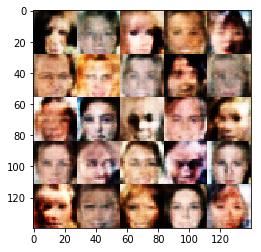

Epoch: 0/1... Discriminator Loss: 0.2359... Generator Loss: 2.9357
Epoch: 0/1... Discriminator Loss: 0.6243... Generator Loss: 4.7694
Epoch: 0/1... Discriminator Loss: 0.4899... Generator Loss: 1.2555
Epoch: 0/1... Discriminator Loss: 0.5437... Generator Loss: 1.1381


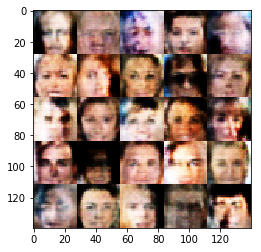

Epoch: 0/1... Discriminator Loss: 0.4054... Generator Loss: 5.3757
Epoch: 0/1... Discriminator Loss: 1.4825... Generator Loss: 6.5346
Epoch: 0/1... Discriminator Loss: 0.9403... Generator Loss: 0.6803
Epoch: 0/1... Discriminator Loss: 1.1995... Generator Loss: 5.3740


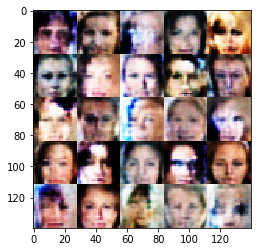

Epoch: 0/1... Discriminator Loss: 0.5219... Generator Loss: 3.2433
Epoch: 0/1... Discriminator Loss: 1.1697... Generator Loss: 6.6042
Epoch: 0/1... Discriminator Loss: 1.1051... Generator Loss: 5.6850
Epoch: 0/1... Discriminator Loss: 0.1195... Generator Loss: 3.9373


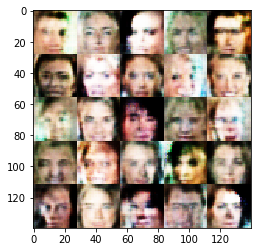

Epoch: 0/1... Discriminator Loss: 0.8690... Generator Loss: 0.6965
Epoch: 0/1... Discriminator Loss: 0.3216... Generator Loss: 1.6683
Epoch: 0/1... Discriminator Loss: 1.1018... Generator Loss: 5.8011
Epoch: 0/1... Discriminator Loss: 0.2124... Generator Loss: 2.4787


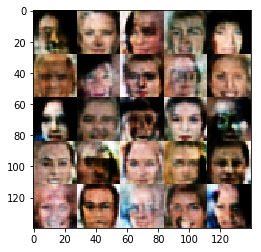

Epoch: 0/1... Discriminator Loss: 0.1379... Generator Loss: 2.9024
Epoch: 0/1... Discriminator Loss: 0.5919... Generator Loss: 1.1789
Epoch: 0/1... Discriminator Loss: 0.9756... Generator Loss: 4.6485
Epoch: 0/1... Discriminator Loss: 0.9044... Generator Loss: 0.6678


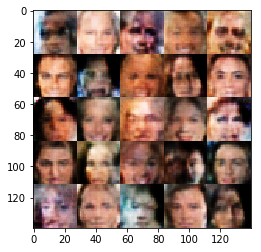

Epoch: 0/1... Discriminator Loss: 0.2640... Generator Loss: 4.1914
Epoch: 0/1... Discriminator Loss: 1.8110... Generator Loss: 2.5189
Epoch: 0/1... Discriminator Loss: 0.8355... Generator Loss: 1.0083
Epoch: 0/1... Discriminator Loss: 0.3352... Generator Loss: 2.4008


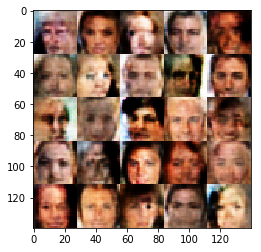

Epoch: 0/1... Discriminator Loss: 0.1455... Generator Loss: 5.8288
Epoch: 0/1... Discriminator Loss: 0.1366... Generator Loss: 3.8452
Epoch: 0/1... Discriminator Loss: 1.4533... Generator Loss: 0.3406
Epoch: 0/1... Discriminator Loss: 1.2905... Generator Loss: 0.4025


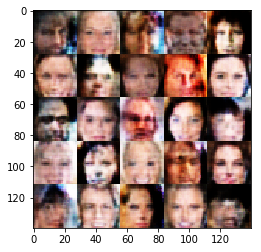

Epoch: 0/1... Discriminator Loss: 0.1860... Generator Loss: 2.6582
Epoch: 0/1... Discriminator Loss: 0.2541... Generator Loss: 1.8269
Epoch: 0/1... Discriminator Loss: 0.4221... Generator Loss: 2.3506
Epoch: 0/1... Discriminator Loss: 0.2346... Generator Loss: 2.5331


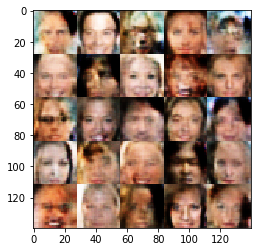

Epoch: 0/1... Discriminator Loss: 0.8111... Generator Loss: 2.1166
Epoch: 0/1... Discriminator Loss: 0.3001... Generator Loss: 1.7417
Epoch: 0/1... Discriminator Loss: 0.2385... Generator Loss: 2.0225
Epoch: 0/1... Discriminator Loss: 0.1383... Generator Loss: 2.6682


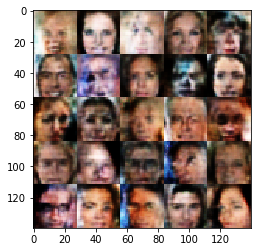

Epoch: 0/1... Discriminator Loss: 0.8096... Generator Loss: 0.8012
Epoch: 0/1... Discriminator Loss: 0.2151... Generator Loss: 2.2657
Epoch: 0/1... Discriminator Loss: 1.2154... Generator Loss: 6.0858
Epoch: 0/1... Discriminator Loss: 0.2494... Generator Loss: 4.9242


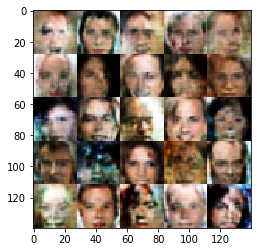

Epoch: 0/1... Discriminator Loss: 1.2592... Generator Loss: 0.4240
Epoch: 0/1... Discriminator Loss: 0.5394... Generator Loss: 1.1341
Epoch: 0/1... Discriminator Loss: 0.6574... Generator Loss: 5.9934
Epoch: 0/1... Discriminator Loss: 1.5630... Generator Loss: 2.6363


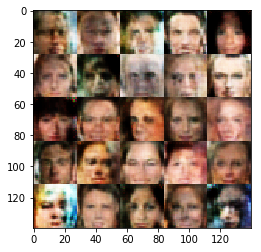

Epoch: 0/1... Discriminator Loss: 0.1707... Generator Loss: 3.9913
Epoch: 0/1... Discriminator Loss: 0.1178... Generator Loss: 3.6481
Epoch: 0/1... Discriminator Loss: 1.7496... Generator Loss: 1.6571
Epoch: 0/1... Discriminator Loss: 0.2061... Generator Loss: 3.4064


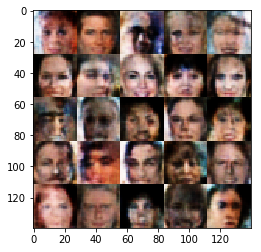

Epoch: 0/1... Discriminator Loss: 0.3749... Generator Loss: 1.3806
Epoch: 0/1... Discriminator Loss: 1.4890... Generator Loss: 1.5658
Epoch: 0/1... Discriminator Loss: 0.1178... Generator Loss: 3.1104
Epoch: 0/1... Discriminator Loss: 0.3287... Generator Loss: 1.6278


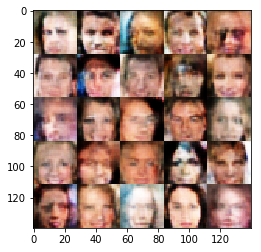

Epoch: 0/1... Discriminator Loss: 1.0432... Generator Loss: 0.5864
Epoch: 0/1... Discriminator Loss: 1.6128... Generator Loss: 2.8981
Epoch: 0/1... Discriminator Loss: 0.3541... Generator Loss: 3.2073
Epoch: 0/1... Discriminator Loss: 0.1598... Generator Loss: 2.7815


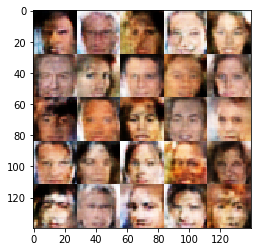

Epoch: 0/1... Discriminator Loss: 0.7536... Generator Loss: 0.7725
Epoch: 0/1... Discriminator Loss: 0.2171... Generator Loss: 2.8658
Epoch: 0/1... Discriminator Loss: 1.0303... Generator Loss: 0.5447
Epoch: 0/1... Discriminator Loss: 1.2290... Generator Loss: 2.4574


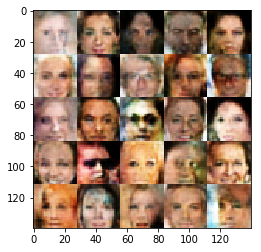

Epoch: 0/1... Discriminator Loss: 0.0871... Generator Loss: 5.1046
Epoch: 0/1... Discriminator Loss: 0.1242... Generator Loss: 3.3098
Epoch: 0/1... Discriminator Loss: 0.6650... Generator Loss: 2.3255
Epoch: 0/1... Discriminator Loss: 0.3368... Generator Loss: 2.8509


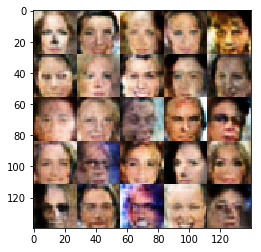

Epoch: 0/1... Discriminator Loss: 0.2361... Generator Loss: 5.7654
Epoch: 0/1... Discriminator Loss: 0.3145... Generator Loss: 1.6842
Epoch: 0/1... Discriminator Loss: 0.3079... Generator Loss: 1.5903
Epoch: 0/1... Discriminator Loss: 2.0093... Generator Loss: 0.2065


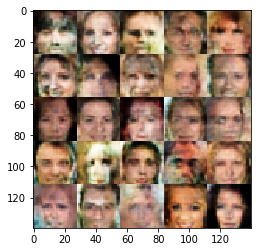

Epoch: 0/1... Discriminator Loss: 0.0829... Generator Loss: 3.8765
Epoch: 0/1... Discriminator Loss: 0.2460... Generator Loss: 2.9302
Epoch: 0/1... Discriminator Loss: 0.8850... Generator Loss: 2.1147
Epoch: 0/1... Discriminator Loss: 0.1911... Generator Loss: 2.3489


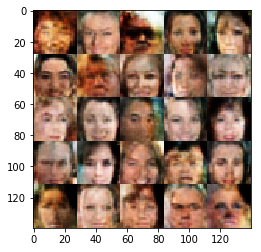

Epoch: 0/1... Discriminator Loss: 0.6487... Generator Loss: 4.9940
Epoch: 0/1... Discriminator Loss: 0.3970... Generator Loss: 1.6822
Epoch: 0/1... Discriminator Loss: 0.2427... Generator Loss: 1.9134
Epoch: 0/1... Discriminator Loss: 0.1068... Generator Loss: 3.9441


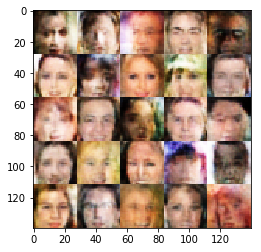

Epoch: 0/1... Discriminator Loss: 0.0687... Generator Loss: 4.3640
Epoch: 0/1... Discriminator Loss: 0.9394... Generator Loss: 1.7504
Epoch: 0/1... Discriminator Loss: 1.6500... Generator Loss: 0.2966
Epoch: 0/1... Discriminator Loss: 0.4191... Generator Loss: 2.3717


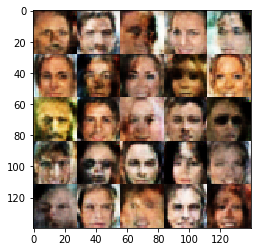

Epoch: 0/1... Discriminator Loss: 0.2336... Generator Loss: 2.3508
Epoch: 0/1... Discriminator Loss: 0.1616... Generator Loss: 2.4962
Epoch: 0/1... Discriminator Loss: 1.0033... Generator Loss: 0.7786
Epoch: 0/1... Discriminator Loss: 0.1250... Generator Loss: 3.6719


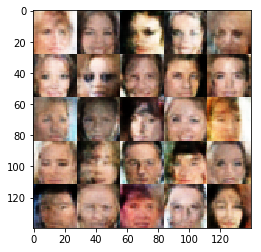

Epoch: 0/1... Discriminator Loss: 0.1830... Generator Loss: 2.6920
Epoch: 0/1... Discriminator Loss: 0.3760... Generator Loss: 1.4567
Epoch: 0/1... Discriminator Loss: 0.2839... Generator Loss: 2.2524
Epoch: 0/1... Discriminator Loss: 0.0907... Generator Loss: 3.6635


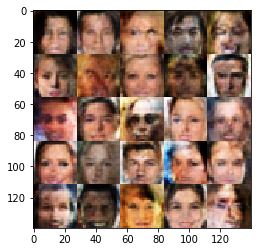

Epoch: 0/1... Discriminator Loss: 0.6261... Generator Loss: 0.9186
Epoch: 0/1... Discriminator Loss: 2.7039... Generator Loss: 3.8669
Epoch: 0/1... Discriminator Loss: 0.1875... Generator Loss: 3.4656


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.